In [40]:
# !pip install numpy pandas matplotlib sympy scipy

# problem 2

A servo motor can be described by the following state equation

$$
\begin{align*}
\begin{bmatrix}
\dot{x_1} \\
\dot{x_2}
\end{bmatrix}
&=
\begin{bmatrix}
0 & 1 \\
0 & -1
\end{bmatrix}
\begin{bmatrix}
x_1 \\
x_2
\end{bmatrix}
+
\begin{bmatrix}
0 \\
1
\end{bmatrix}
u(t)
\end{align*}
$$

Where x_1  is the angular position, x_2  is the angular velocity of the motor shaft and u(t) is the applied voltage. A control system is designed to drive the angular position to zero using the input u(t). Find an optimum input u(t) that derives the system from 30 degrees angular position of the shaft to zero in 25 seconds while minimizing the cost function given by


\begin{align*}
J&= 1/2  \begin{bmatrix}
x_1 (25) \\
x_2 (25)
\end{bmatrix}^T P \begin{bmatrix}
x_1 (25) \\
x_2 (25)
\end{bmatrix} + 1/2 \int_{0}^{25} \left( \begin{bmatrix}
x_1 (t) \\
x_2 (t)
\end{bmatrix}^T Q \begin{bmatrix}
x_1 (t) \\
x_2 (t)
\end{bmatrix} + ru^2 (t) \right) dt
\end{align*}



a.	Assuming fixed final state, solve for optimal feedback control for two different sets of P, Q, and r.

b.	How is the optimal cost inluenced by the selection of P, Q, and r?

c.	Rework parts (a) and (b) if the final state is free.



## imports 

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sympy as sp
import scipy as sc

from sympy import symbols, Eq, solve, simplify, MatrixSymbol
from pprint import pprint
from IPython.display import display, Math

from continuous_system import system

%load_ext autoreload
%autoreload 2

## define the system and cost functions

# part a

we have considered R, Q and P are all identity matrices multiplied by some scalar values.

system dynamics:


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

path cost:


<IPython.core.display.Math object>

Hamiltonian:


<IPython.core.display.Math object>

State equation:


<IPython.core.display.Math object>

Costate equation:


<IPython.core.display.Math object>

<IPython.core.display.Math object>

Stationarity equation:


<IPython.core.display.Math object>

Optimal control:


<IPython.core.display.Math object>

the optimal input for the fixed final time problem is:


<IPython.core.display.Math object>

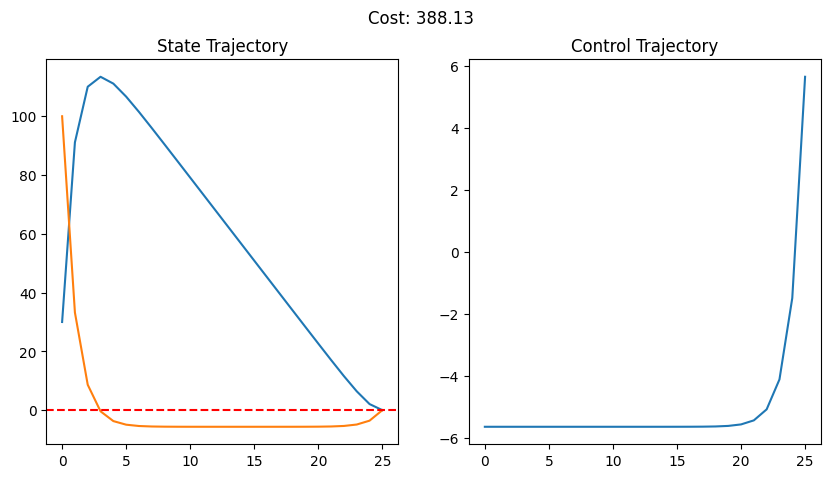

In [5]:
# we are assuming a time invariant system
a_val = sp.Matrix([[0, 1], [0, -1]])
b_val = sp.Matrix([[0], [1]])

# cost_k = .5 * u_k.T * R * u_k + .5 * (x_k.T * Q * x_k)

N_val = 25
x0 = sp.Matrix([30, 100])                # initial state, x1=30, let x2=30
rN = sp.Matrix([0, 0])

R_val = sp.Matrix([[1]])                # input cost
Q_val = sp.Matrix([[1, 0], [0, 1]])     # state cost, Q term
Sn_val = sp.Matrix([[1, 0], [0, 1]])    # terminal state cost, P term

sys = system(a_val, b_val, silent=False)

result = sys.fixed_final_optimal_control(Q_val, R_val, Sn_val, x0, rN, N_val)

the optimal input for the fixed final time problem is:


<IPython.core.display.Math object>

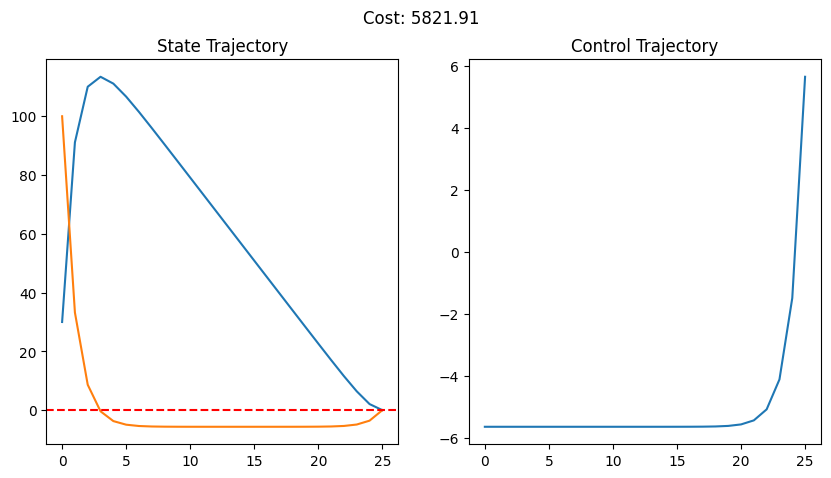

In [6]:
# we are assuming a time invariant system
a_val = sp.Matrix([[0, 1], [0, -1]])
b_val = sp.Matrix([[0], [1]])


N_val = 25
x0 = sp.Matrix([30, 100])                # initial state, x1=30, let x2=30
rN = sp.Matrix([0, 0])

R_val = sp.Matrix([[1]]) * 15             # input cost
Q_val = sp.Matrix([[1, 0], [0, 1]])     # state cost, Q term
Sn_val = sp.Matrix([[1, 0], [0, 1]])    # terminal state cost, P term

sys = system(a_val, b_val)

result = sys.fixed_final_optimal_control(Q_val, R_val, Sn_val, x0, rN, N_val)


# part b
as the final state is fixed, P and Q does not have any effect on the optimal control. only the value of r will affect the optimal control. This is the open loop control.
# part c

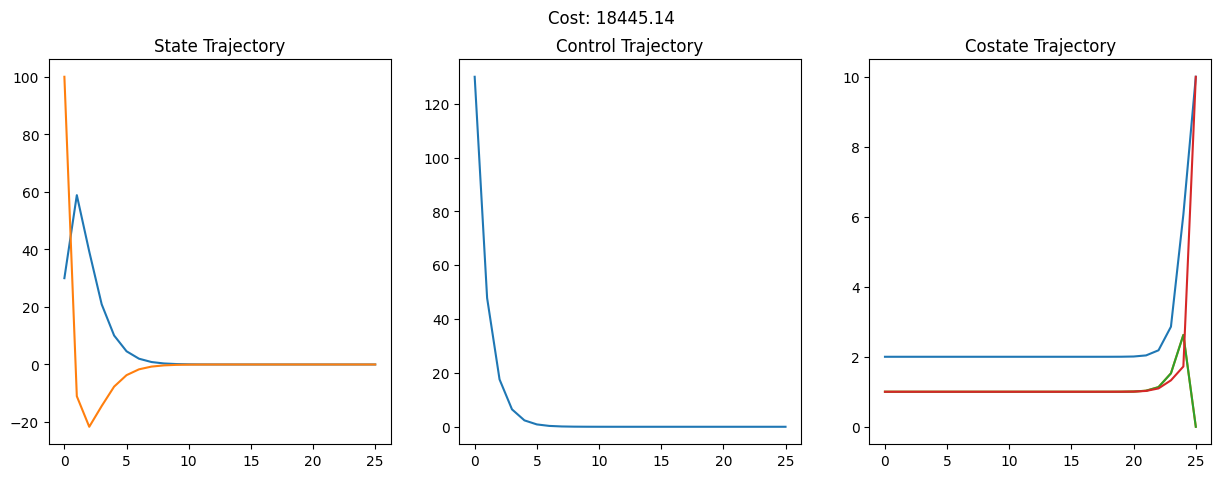

In [9]:
# we are assuming a time invariant system
a_val = sp.Matrix([[0, 1], [0, -1]])
b_val = sp.Matrix([[0], [1]])


N_val = 25
x0 = sp.Matrix([30, 100])                # initial state, x1=30, let x2=30
rN = sp.Matrix([0, 0])

R_val = sp.Matrix([[1]])                # input cost
Q_val = sp.Matrix([[1, 0], [0, 1]])     # state cost, Q term
Sn_val = sp.Matrix([[1, 0], [0, 1]]) *10    # terminal state cost, P term

sys = system(a_val, b_val)

result = sys.free_final_optimal_control(Q_val, R_val, Sn_val, x0, rN, N_val)

now lets test this out with different weighting values.

In [462]:
r_range = np.linspace(1, 500, 20)
q_range = np.linspace(0, 500, 20)
sn_range = np.linspace(1, 100, 1)

R_val = sp.Matrix([[1]])                # input cost
Q_val = sp.Matrix([[1, 0], [0, 1]])     # state cost, Q term
Sn_val = sp.Matrix([[1, 0], [0, 1]])    # terminal state cost, P term


results = []
trajectories = []
costs = []  
for s, snval in enumerate(sn_range):
    print(f"woking on {s+1}/{len(sn_range)}")
    snval = Sn_val * snval
    result = np.zeros((len(r_range), len(q_range)))
    for i, rval in enumerate(r_range):
        print("1", end="")
        rval = R_val * rval
        for j, qval in enumerate(q_range):
            print("2", end="")
            qval = Q_val * qval
            r = sys.free_final_optimal_control(qval, rval, snval, x0, rN, N_val, plot=False)
            result[i, j] = r[-1]
            trajectories.append(r[0])
            costs.append(r[-1])
    results.append(result)
    print("")
results = np.array(results)
results = results/np.max(results)

woking on 1/1
122222222222222222222122222222222222222222122222222222222222222122222222222222222222122222222222222222222122222222222222222222122222222222222222222122222222222222222222122222222222222222222122222222222222222222122222222222222222222122222222222222222222122222222222222222222122222222222222222222122222222222222222222122222222222222222222122222222222222222222122222222222222222222122222222222222222222122222222222222222222


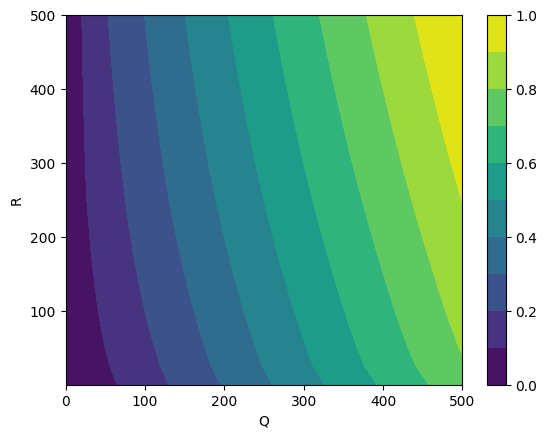

In [463]:
for result in results:
    fig, ax = plt.subplots()
    c = ax.contourf(q_range, r_range, result, levels=10)
    ax.set_xlabel("Q")
    ax.set_ylabel("R")
    fig.colorbar(c)
    plt.show()

Text(0.5, 0.98, 'Trajectories')

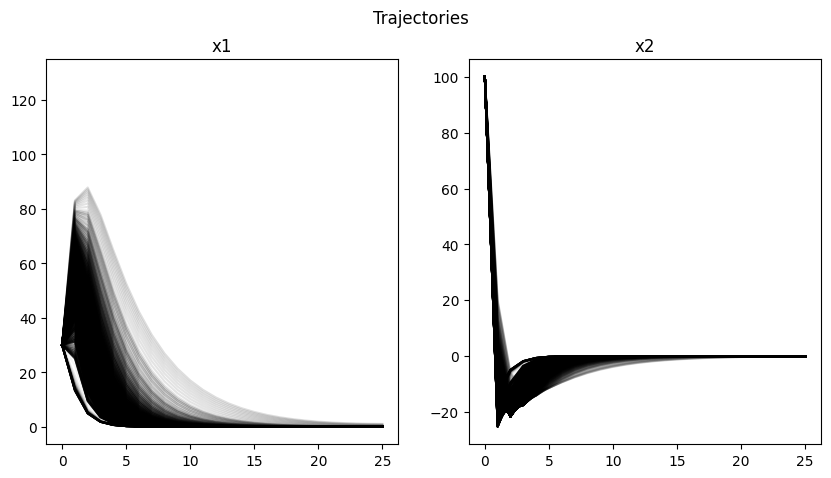

In [467]:
trajectories = np.array(trajectories)
_costs = np.array(costs).astype(float)
_costs = _costs/np.max(_costs)

fig, [ax,bx] = plt.subplots(1, 2, figsize=(10, 5))


for i in range(trajectories.shape[0]):
    ax.plot(trajectories[i][:,0], color="black", alpha=_costs[i])
    bx.plot(trajectories[i][:,1], alpha=_costs[i], color="black")
ax.set_title("x1")
bx.set_title("x2")
fig.suptitle("Trajectories")

higher alpha indicates higher cost value. 

The value of S does not have any major effect because the final state is very close to zero with this initial condition. 

The cost goes up with the increase in r and Q values.